# Pytorch Deep Neural Network V4
## Analysis of Gregor Dataset (Top Tagging)

### Has real time plotting of training

# 4 hidden layer NN

## Started May 24, 2019
### Genevieve Hayes


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
import seaborn as sb
import matplotlib.pylab as plt
#import matplotlib as mpl
import h5py
import tables
import math
import time
import sklearn.metrics as sklm

In [2]:
run_gpu=False
if run_gpu:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")

In [5]:
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split

# Training dataset loading class
class TrainDataset(Dataset):
    # Initialize our data, download, etc.  
    def __init__(self):
        #open hdf5 file for reading
        hdf_train = pd.HDFStore('train.h5',mode='r')
        hdf_train.keys()
        table_train = hdf_train.get('/table')
        
        #numpy representation of DataFrame
        array_train = table_train.values
        
        self.len = array_train.shape[0]
        self.x_data = torch.from_numpy(array_train[:,0:800]).float() #x data is only the 4 vectors of the constituents 
        self.y_data = torch.from_numpy(array_train[:,-1]).long() #y data is only the labels (0=QCD, 1=top)
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len
    
# Validation dataset loading class
class ValDataset(Dataset):
    # Initialize our data, download, etc.
    def __init__(self):
        #open hdf5 file for reading
        hdf_val = pd.HDFStore('val.h5',mode='r')
        hdf_val.keys()
        table_val = hdf_val.get('/table')
        
        #numpy representation of DataFrame
        array_val = table_val.values
        
        self.len = array_val.shape[0]
        self.x_data = torch.from_numpy(array_val[:,0:800]).float()
        self.y_data = torch.from_numpy(array_val[:,-1]).long()
        
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len
    
# # Testing dataset loading class
# class TestDataset(Dataset):
#     # Initialize our data, download, etc.
#     def __init__(self):
#         #open hdf5 file for reading
#         hdf_test = pd.HDFStore('test.h5',mode='r')
#         hdf_test.keys()
#         table_test = hdf_test.get('/table')
        
#         #numpy representation of DataFrame
#         array_test = table_test.values
        
#         self.len = array_test.shape[0]
#         self.x_data = torch.from_numpy(array_test[:,0:800]).float()
#         self.y_data = torch.from_numpy(array_test[:,-1]).long()
        
#     def __getitem__(self,index):
#         return self.x_data[index],self.y_data[index]
    
#     def __len__(self):
#         return self.len


In [7]:
training_dataset = TrainDataset()
validation_dataset = ValDataset()
# testing_dataset = TestDataset()

train_len = training_dataset.len
val_len = validation_dataset.len
# test_len = testing_dataset.len

## Net Structure 

In [8]:
# Creating Network Structure class in PyTorch way
class Net(torch.nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        
        #Input layer is 200 constituents each with 4 features
        self.linear1 = nn.Linear(800,500) #4 hidden layers
        self.linear2 = nn.Linear(500,300)
        self.linear3 = nn.Linear(300,60)    
        self.linear4 = nn.Linear(60,6)
        #1 output (top or qcd)
        self.linear5 = nn.Linear(6,2) 
        
    def forward(self, x):
#        x = x.view(,-1) #Flatten the data
        out1 = F.relu(self.linear1(x))
        out2 = F.relu(self.linear2(out1))
        out3 = F.relu(self.linear3(out2))
        out4 = F.relu(self.linear4(out3))
        #y_pred = F.softmax(self.linear5(out4),1) #softmax activation function
        y_pred = torch.sigmoid(self.linear5(out4)) #sigmoid activation function
        #y_preds.size() --> 5000, 2
        return y_pred

model = Net()

## Construct Loss and Optimizer

In [9]:
num_epochs = 4
batch_len = 10000
learning_rate = 0.001

In [10]:
#criterion = torch.nn.BCELoss()
criterion = nn.CrossEntropyLoss()

#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.5) #Stochastic Gradient Descent with momentum
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #ADAM optimizer

In [11]:
# make dataloaders
training_loader = DataLoader(dataset=training_dataset, batch_size=batch_len, shuffle=True, num_workers=2)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_len, shuffle=False, num_workers=2)
# testing_loader = DataLoader(dataset=testing_dataset, batch_size=500, shuffle=False, num_workers=2)


In [12]:
for i, data in enumerate(training_loader, 0):
        ### 1. get the inputs ###
        inputs,labels=data
        
        ### 2. wrap them in Variable ###
        inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Forward pass: Compute predicted y by passing x to the model
        outputs=model(inputs)
        preds=torch.max(outputs.data,1)[1]
        #preds has size [batch_size]
        
#check size and shape of labels, inputs, outputs

#print(labels.shape)    #= torch.Size([500])
#print(inputs.shape)    #= torch.Size([500, 800])
#print(outputs.shape)   #= torch.Size([500, 2])

## Train the neural network

In [13]:
print(training_loss_list)

NameError: name 'training_loss_list' is not defined

In [ ]:
start_time = time.time()

training_loss_list=[]
validation_loss_list=[]
testing_loss_list=[]

training_acc_list=[]
validation_acc_list = []
testing_acc_list=[]

for epoch in range(num_epochs):
#Training cycle (forward, backward, update)
    if (epoch%1==0 or epoch==num_epochs - 1):
        print('Epoch {}/{}'.format(epoch, num_epochs -1))
        print('-' * 2)
        
    model.train()
    train_loss = 0.0
    train_corrects = 0
    
    for i, data in enumerate(training_loader, 0):
        
        ### 1. get the inputs ###
        inputs,labels=data
        
        ### 2. wrap them in Variable ###
        inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = inputs.to(device), labels.to(device)
        
        #Forward pass: Compute predicted y by passing x to the model
        outputs=model(inputs)
        preds=torch.max(outputs.data,1)[1]
        
        #Compute loss
        loss=criterion(outputs,labels)
        
        #Zero gradients, perform a backward pass, and update the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*inputs.size(0)
        
        #extract TP+TN
        train_corrects += torch.sum(preds == labels.data)
        
    epoch_loss = train_loss/train_len
    epoch_acc = train_corrects.double()/train_len
    
    training_loss_list.append(epoch_loss)
    training_acc_list.append(epoch_acc)
    
    #Visualization
    print('Training Accuracy:{:.4f}'.format(epoch_acc))
    if (epoch%2==0 or epoch==num_epochs - 1):
    
        counter = range(epoch+1)
        figtrain = plt.figure()
        axtrain = figtrain.add_subplot(111)
        plt.plot(counter,training_loss_list,'-*r',linestyle = 'solid',label="training loss")
#Validation cycle (forward, save)
    model.eval()
    val_loss=0
    val_corrects=0
    
    with torch.no_grad():
        for data in validation_loader:
            inputs,labels=data
            inputs,labels = Variable(inputs), Variable(labels)
            outputs = model(inputs)
            #sum up batch loss
            loss = criterion(outputs,labels)
            #get the index of the max log-probability
            preds=torch.max(outputs.data,1)[1]
            val_loss += loss.item()*inputs.size(0)
            
            #extract TP+TN
            val_corrects += torch.sum(preds == labels.data)
                                       
        epoch_loss = val_loss / val_len
        epoch_acc = val_corrects.double() / val_len
        
        validation_loss_list.append(epoch_loss)
        validation_acc_list.append(epoch_acc)

        #Visualization
        print('Validation Accuracy:{:.4f} \n'.format(epoch_acc))
        if (epoch%2==0 or epoch==num_epochs - 1):
            counter = range(epoch+1)
            plt.plot(counter,validation_loss_list,'-*g',linestyle = 'solid',label="validation loss")
        
            plt.title('Loss as a function of epoch',color='w')
            plt.xlabel('Epoch',color='w')
            plt.ylabel('Loss',color='w')
            axtrain.spines['bottom'].set_color('white')
            axtrain.spines['top'].set_color('white')
            axtrain.tick_params(axis='x', colors='white')
            axtrain.tick_params(axis='y', colors='white')
            plt.legend(loc='upper right')
            plt.show()

        
# #Testing cycle (forward, save)
#     model.eval()
#     test_loss=0
#     test_corrects=0
    
#     with torch.no_grad():
#         for data in testing_loader:
#             inputs,labels=data
#             inputs,labels = Variable(inputs), Variable(labels)
#             outputs = model(inputs)
#             #sum up batch loss
#             loss = criterion(outputs,labels)
#             #get the index of the max log-probability
#             preds=torch.max(outputs.data,1)[1]
#             test_loss += loss.item()*inputs.size(0)
#             test_corrects += torch.sum(preds == labels.data)
            
#         epoch_loss = test_loss / test_len
#         epoch_acc = test_corrects.double() / test_len
        
#         testing_loss_list.append(epoch_loss)
#         testing_acc_list.append(epoch_acc)
        
end_time = time.time()   
print("--- {} seconds ---".format(end_time-start_time)) 
print("--- {} min and {} sec ---".format(math.floor((end_time-start_time)/60),math.ceil((end_time-start_time)%60)))

## Evaluate model

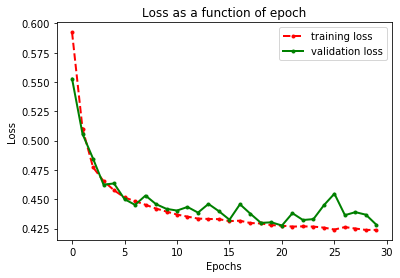

In [257]:
x=range(num_epochs)
y_train=training_loss_list
y_val = validation_loss_list
#y_test=testing_loss_list

fig = plt.figure()
ax1 = fig.add_subplot(111)
plt.plot(x,y_train,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='r',label="training loss")
plt.plot(x,y_val,marker='o',markersize=3,linewidth=2,linestyle = 'solid', color='g',label="validation loss")
#plt.plot(x,y_test,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='b',label="test loss")
plt.title('Loss as a function of epoch')#,color='w')


#ax1.spines['bottom'].set_color('white')
#ax1.spines['top'].set_color('white')
#ax1.xaxis.label.set_color('white')
#ax1.yaxis.label.set_color('white')
#ax1.tick_params(axis='x', colors='white')
#ax1.tick_params(axis='y', colors='white')

ax1.set_xlabel('Epochs')#, color='white')
ax1.set_ylabel('Loss')#, color='white')

plt.legend(loc='upper right')
plt.legend()
plt.show()

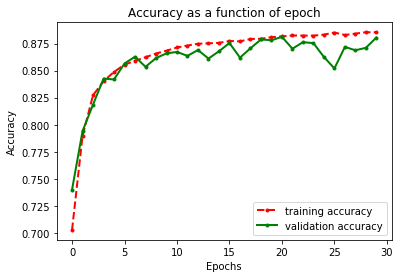

In [270]:
x=range(num_epochs)
y_train=training_acc_list
y_val = validation_acc_list
#y_test=testing_acc_list

fig2 = plt.figure(2)
ax2 = fig2.add_subplot(111)

plt.plot(x,y_train,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='r',label="training accuracy")
plt.plot(x,y_val,marker='o',markersize=3,linewidth=2,linestyle = 'solid', color='g',label="validation accuracy")
#plt.plot(x,y_test,marker='o',markersize=3,linewidth=2,linestyle='dashed',color='b',label="test accuracy")
plt.title('Accuracy as a function of epoch')#,color='w')

#ax2.spines['bottom'].set_color('white')
#ax2.spines['top'].set_color('white')
#ax2.xaxis.label.set_color('white')
#ax2.yaxis.label.set_color('white')
#ax2.tick_params(axis='x', colors='white')
#ax2.tick_params(axis='y', colors='white')

ax2.set_xlabel('Epochs')#, color='white')
ax2.set_ylabel('Accuracy')#, color='white')

plt.legend(loc='upper right')
plt.legend()
plt.show()

# Confusion Matrix

In [271]:
validation_confusion_matrix = sklm.confusion_matrix(labels.data,preds)
tn, fp, fn, tp = sklm.confusion_matrix(labels.data,preds).ravel()

print('TN = {}, FP = {}, FN = {}, TP = {}\n'.format(tn, fp, fn, tp))
print('Confusion matrix of validation data:\n',validation_confusion_matrix)


TN = 1250, FP = 250, FN = 100, TP = 1400

Confusion matrix of validation data:
 [[1250  250]
 [ 100 1400]]


# Precision, Recall and F-measure

In [272]:
precision = sklm.precision_score(labels.data,preds)
#print('Precision: {:.4f}'.format(precision))
recall = sklm.recall_score(labels.data,preds)
#print('Recall: {:.4f}'.format(recall))
f1 = sklm.f1_score(labels.data,preds)
#print('F1: {:.4f}'.format(f1))

from IPython.display import HTML, display
import tabulate
table = [["Precision","{:.3f}".format(precision)],
         ["Recall","{:.3f}".format(recall)],
         ["F1","{:.3f}".format(f1)]]
        
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Precision,0.848
Recall,0.933
F1,0.889


# ROC Curve and AUC

AUC: 0.9210


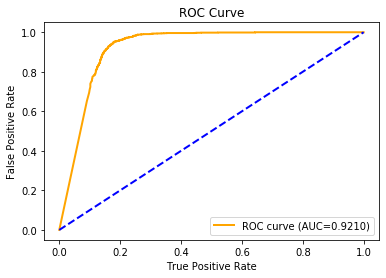

In [273]:
fpr, tpr, thresholds = sklm.roc_curve(labels.data,outputs.data[:,1],pos_label=None)

auc = sklm.roc_auc_score(labels.data,outputs.data[:,1])

print('AUC: {:.4f}'.format(auc))


#ROC curve
fig3 = plt.figure(3)
ax3 = fig3.add_subplot(111)

#plt.plot(fpr,tpr)
plt.plot(fpr,tpr,linewidth=2,linestyle='solid',color='orange',label="ROC curve (AUC={:.4f})".format(auc))
plt.plot(fpr,fpr,linewidth=2,linestyle='dashed',color='b')
plt.title('ROC Curve')#,color='w')

# ax3.spines['bottom'].set_color('white')
# ax3.spines['top'].set_color('white')
# ax3.xaxis.label.set_color('white')
# ax3.yaxis.label.set_color('white')
# ax3.tick_params(axis='x', colors='white')
# ax3.tick_params(axis='y', colors='white')

ax3.set_xlabel('True Positive Rate')#, color='white')
ax3.set_ylabel('False Positive Rate')#, color='white')

plt.legend(loc='lower right')
plt.legend()
plt.show()

In [262]:
# THIS IS STILL NOT IDEAL
#to catch divisions by zero

def safe_div(x,y):
    division = np.empty(np.size(y))
    for idx in range(np.size(y)):
        if y[idx] == 0:
            division[idx] = x / 0.00001
        else:
            division[idx] = x / y[idx]       
    return division

background_rejection = safe_div(1,fpr)

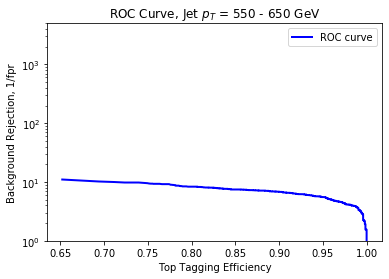

0.0


In [267]:
background_rejection = safe_div(1,fpr)
#background_rejection = 1/fpr[2:] #the first and second elements of fpr are usually zero, so disregard these to avoid divide by zero

#ROC curve (using background rejection)
fig4 = plt.figure(4)
ax4 = fig4.add_subplot(111)

#plt.plot(fpr,tpr)
plt.semilogy(tpr[1:],background_rejection[1:],linewidth=2,linestyle='solid',color='blue',label="ROC curve")
#plt.plot(background_rejection,background_rejection,linewidth=2,linestyle='dashed',color='b')
plt.title('ROC Curve, Jet $p_T$ = 550 - 650 GeV')#,color='w')

# ax4.spines['bottom'].set_color('white')
# ax4.spines['top'].set_color('white')
# ax4.xaxis.label.set_color('white')
# ax4.yaxis.label.set_color('white')
# ax4.tick_params(axis='x', colors='white')
# ax4.tick_params(axis='y', colors='white')

ax4.set_xlabel('Top Tagging Efficiency')#, color='white')
ax4.set_ylabel('Background Rejection, 1/fpr')#, color='white')

plt.ylim(1, 5000)

plt.legend(loc='upper right')
plt.legend()
plt.show()

print(fpr[0])

In [268]:
#indexing function to find % signal efficiency

def find_nearest_ind(array,value):
    array = np.asarray(array)
    ind = (np.abs(array-value)).argmin()
    return ind, array[ind]

In [269]:
#looking for 50% signal efficiency
index_20,signal_efficiency_20 =find_nearest_ind(tpr,0.2)
index_50,signal_efficiency_50 =find_nearest_ind(tpr,0.5)
index_80,signal_efficiency_80 =find_nearest_ind(tpr,0.8)

#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_20*100,background_rejection[index_20]))
#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_50*100,background_rejection[index_50]))
#print('Background rejection at {:.1f}% signal efficiency: {:.3}\n'.format(signal_efficiency_80*100,background_rejection[index_80]))

from IPython.display import HTML, display
import tabulate
table = [["Signal Efficiency","Background Rejection"],
         ["{:.1f}".format(signal_efficiency_20*100),"{:.2f}".format(background_rejection[index_20])],
         ["{:.1f}".format(signal_efficiency_50*100),"{:.2f}".format(background_rejection[index_50])],
         ["{:.1f}".format(signal_efficiency_80*100),"{:.2f}".format(background_rejection[index_80])]]
display(HTML(tabulate.tabulate(table, tablefmt='html')))

Signal Efficiency,Background Rejection
0.0,100000.00
65.2,11.03
80.0,8.33


In [185]:
#Would like a DNN distribution for the signal and background samples (probability density as a function of neural network output)
#plt.plot(outputs.data[:,1])
#print(outputs.data[:,1])